# V2: Personalized Feed Recommendations

In the first generation of our algorithm (V1), we focused on the use of *shared categories (preferences)* to curate a feed for the user. This was mostly because we did not yet have social data points like engagements and networking (following, etc.)

The obvious limitation of V1 was that the resulting feed could never truly be **personalized** as it did not depend on the specific behaviour or interactions of the user, therefore users with similar preferences would likely be served similar feeds; this is still better than showing everyone exactly the same feed (the case if we did not have an algorithm), but we realized that the feed can be much better with *personalization*.

Hence, **V2** (codename: **Phoenix**) was born.

## Feed Personalization with Phoenix

The core philosophy of Phoenix is that the **relevance of posts and creators to a user is established through interaction and engagement** with those posts and creators i.e. it is a *social* algorithm. However Phoenix does not apply bias in the form of weights on the specific values of these datapoints for each post or creator. Instead it looks at the **content** and applies an objective measure of relevance i.e. *post similarity*.

<img src="../docs/phoenix_recommendation_flow.png" alt="Phoenix Philosophy">

In Phoenix, when a user comments on posts or reads posts for a significant duration of time (alternative to `like`), similar posts are recommended for the user. Also when a user follows creators and views creator profiles, those creators' recent posts and similar posts are recommended for the user. 

This technique is called **social aggregation** and it ensures that we have a feed that is truly `personalized` and `relevant` for each user.

## Phoenix Architecture

<img src="../docs/v2_architecture.png" alt="V2 architecture">

### Data Sourcing

V2 primarily ingests event data from Mixpanel that is synced every scan interval to our BigQuery data warehouse.

Currently, we ingest the following events:

**Post** events:

- `content_view_open`
- `content_view_time_on_page`
- `give_a_comment`
- `content_view_click`


**Profile** events:

- `profile_view`
- `follow_user`

The extracted events are compiled into a data resource called a **Training Schedule** which is basically a mapping of **user ids** that were discovered in the events to the **post ids** that were referenced by those events (relative to each user).

If the event is a *profile event*, then we fetch the ids of all recent posts created by the owner of that profile and update the training schedule.


### Data Ingestion

Phoenix ingests these **training schedules** and updates **datasets** in our Redis vector databases, which reside on the Orchestration Server.

### Training Step: TF-IDF Vectorization

*Term Frequency - Inverse Document Frequency* (TF-IDF) is a well-known and widely-used algorithm for determining the importance (relevance) of a word in a given document (e.g. a Post).

Our approach in V2 is to leverage TF-IDF to build an index of words and their relative importance in every post we scan. The relevance data is updated using the `TfIdfVectorizer` from the Scikit-learn Python package and the resulting vectors are stored as a `Semantic Index` dataset in our Redis vector database. We also store a **corpus** which is like a special dictionary containing tuples of every unique **wordset** we have scanned, its hash and also the post id.

### Vector Databases

As mentioned previosuly, we use Redis as a **vector database**, and we store two primary datasets:

- `V2_SYS_CORPUS`
- `V2_SYS_SEMANTIC_INDEX`

We have one of these for each **data environment**: `integration`, `stage` and `prod`.

### Recommender System

The V2 recommender system is based on the principle of *vector search*. It uses vector search to return the closest matches to any given input post.

#### Vector Search Operation

- the first step is to transform an input post into a **wordset** which is an ordered list of useful words in the post
- the second step is to find all posts in the vector dataset which contain any of the words in the wordset and extract the corresponding vectors (TF-IDF scores)
- we then compute **match counts**, **cummulative scores** and also **post recency coefficients** for each post in the index that matches any of the words in the input wordset.
- finally we multiply these factors together and rank the search results in descending order of that product


## Text distribution in Taringa! content: Justifying the approach for V2

**94%** of content published on Taringa! contains **text** in at least one location: *title*, *body* or both.

Phoenix consumes this text data from the multiple locations in each Post object scanned and this is used to build the semantic indexes.

Because we can have up to 94% theoretical coverage of posts in the index (at full indexing potential), the recommendations of V2 are already at a high level of confidence, and we will be evaluating that as well in this document.

<br><img src="../docs/taringa_content_distribution.png" alt="Taringa! content distribution">

## Evaluation Rubric

In evaluating V2, we will empirically test the following concepts:

- `Random Training in Phoenix` (Indexing - building datasets)
    - Average random training time
- `Event Training in Phoenix` (Indexing and making recommendations)
    - Average event training time
- `Analyzing the Corpus`
- `Analyzing the Semantic Index`
- `Sanity test of recommended posts`


## Test Framework

The following code constitutes a test framework that will be used for the evaluations:

In [1]:
from typing import Any, Tuple, Callable, Union, List
import requests as http
from dotenv import dotenv_values
from datetime import datetime
from statistics import mean
import numpy as np
from random import sample
import seaborn as sns

def get_env_secret(secret_name: str) -> str:
    return dotenv_values().get(secret_name)

V2_TASK_URL_FORMAT = "http://%s:%s/v2-task?%s"
FETCH_DOCS_URL_FORMAT = "http://%s:%s/test-fetch-docs?%s"
TEST_API_KEY = get_env_secret(secret_name='TEST_API_KEY')
V2_SERVER_ADDRESS = get_env_secret(secret_name='V2_SERVER_ADDRESS')
V2_SERVICE_PORT = get_env_secret(secret_name='V2_SERVICE_PORT')
MAX_DOCS_TO_FETCH = 20

def now():
    return datetime.now()

def elapsed_secs(t: datetime) -> float:
    return (now() - t).total_seconds()

class IQRComputation:
    def __init__(self, dataset: Union[List[float], List[int]]) -> None:
        self.dataset = dataset
        self.Q1 = None
        self.Q3 = None
        self.IQR = None
        self.lower_bound = None
        self.upper_bound = None
        self.outliers = []
        self.filtered = []

    def get_percentiles(self):
        if self.dataset:
            self.Q1, self.Q3 = np.percentile(self.dataset, [25, 75])
        return self

    def build_IQR(self):
        if self.Q1 and self.Q3:
            self.IQR = self.Q3 - self.Q1
            self.lower_bound = self.Q1 - 1.5 * self.IQR
            self.upper_bound = self.Q3 + 1.5 * self.IQR
            for i in self.dataset:
                if not (self.lower_bound <= i <= self.upper_bound):
                    self.outliers.append(i)
                else:
                    self.filtered.append(i)
        return self

def get_headers():
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {TEST_API_KEY}"
    }

def parse_query_params(params_dict: dict) -> str:
    query_params = "&".join([f"{key}={value}" for key,value in params_dict.items()])
    return query_params

def build_v2_task_url(task_params: dict, docs_task: bool) -> str:
    query_params = parse_query_params(params_dict=task_params)
    url_format = V2_TASK_URL_FORMAT if not docs_task else FETCH_DOCS_URL_FORMAT
    return url_format % (V2_SERVER_ADDRESS, V2_SERVICE_PORT, query_params)

def run_v2_task(task_params: dict, docs_task: bool = False) -> Any:
    task_started = now()
    task_response = http.get(url=build_v2_task_url(task_params=task_params, docs_task=docs_task), headers=get_headers())
    task_result = task_response.json()
    task_duration_secs = elapsed_secs(t=task_started)
    return task_result, task_duration_secs

def v2_random_train(env: str = "stage") -> Tuple[Any, float]:
    task_params = dict(m="random-train", env=env, wr=True)
    _, duration = run_v2_task(task_params=task_params)
    return None, duration

def v2_event_train(scan_minutes: int = 200, env: str = "prod") -> Tuple[Any, float]:
    task_params = dict(m="event-train", sm=scan_minutes, env=env, wr=True)
    return run_v2_task(task_params=task_params)

def v2_fetch_corpus(env: str = "stage") -> dict:
    task_params = dict(m="fetch-v2-corpus", env=env, wr=True)
    return run_v2_task(task_params=task_params)

def v2_fetch_index(env: str = "stage") -> dict:
    task_params = dict(m="fetch-v2-index", env=env, wr=True)
    return run_v2_task(task_params=task_params)

def task_performance(task: Callable, task_params: dict = {}, n_iter: int = 20) -> Tuple[float, int, int]:
    _times = []
    n_success = 0
    n_failed = 0
    for i in range(n_iter):
        try:
            _, runtime = task(**task_params)
            _times.append(runtime)
            n_success += 1
        except Exception as err:
            n_failed += 1
    outlier_filter = IQRComputation(dataset=_times)
    filter_result = outlier_filter.get_percentiles().build_IQR()
    return mean(filter_result.filtered), n_success, n_failed, len(filter_result.outliers), sns.scatterplot(data=filter_result.filtered)
            
def fetch_docs(collection: str, ids: List[str] = None, fields: List[str] = None, env: str = "stage") -> Tuple[Any, float]:
    size, = sample(range(MAX_DOCS_TO_FETCH), 1)
    task_params = dict(env=env, collection=collection, size=size)
    extra_args = dict()
    if ids:
        extra_args = {**extra_args, **{"ids": ",".join(ids)}}
    if fields:
        extra_args = {**extra_args, **{"fields": ",".join(fields)}}
    task_params.update(extra_args)
    return run_v2_task(task_params=task_params, docs_task=True)
    

## Random Training in Phoenix

Random training refers to the process of training the V2 algorithm ("Phoenix") using new posts from any target environment. Currently, by default this will train on the newest 1,000 posts in that environment.

In this evaluation, we use the `v2_random_train` function to invoke random training in the (default) `Staging` environment. Later we will be analyzing the `corpus` and `semantic_index` datasets that are updated by this training.

We are interested in benchmarking the activity, so that we can have a sense of how long the training takes on average.

Our **test server** (where Phoenix is currently deployed for evaluation) has the following specifications:

- **Machine Type**: E2-MEDIUM (Google Cloud Platform)
- **RAM**: 4GB
- **Cores**: 2
- **Architecture**: x86/64 (Intel Broadwell)

In [ ]:
task_performance(task=v2_random_train, task_params=dict(env="prod"), n_iter=100)

### Benchmarking process

During the experiment, we performed 100 iterations of random training (indexing), each time recording the duration of the session. Our benchmarking function was able to filter out outliers, compute the average duration of the filtered dataset and give us counts of successful/failed experiments as well as a plot of the valid durations.

### Results

- **Average training time**: 10 sec
- **Indexing rate**: 100 posts/sec
- **Successful experiments**: 100%
- **Failed experiments**: 0%
- **Outlier rate**: 11%

## Event Training (building recommendations) in Phoenix

In event training, Phoenix performs an end-to-end flow beginning with events being scanned from the data warehouse (we must specify an interval to scan, say the last 5 minutes) and compiled to create a training schedule, which is a mapping of user ids found in the events analyzed to the post ids (and exclusion sets) referenced by those user ids. 

Once the training schedule is ready, it is fed into a process that updates the semantic index (relevance datastructure) and corpus (store of unique wordsets).

In the last stage, the referenced posts are used to lookup similar posts in the updated semantic index via a vector search operation.

### Benchmarking process

We limited the experiment to 20 iterations of event training in the `prod` environment (there are no `non-prod` events synced to our DW). Our benchmarking function was able to filter out outliers, compute the average duration of the filtered dataset and give us counts of successful/failed experiments as well as a plot of the valid durations.

### Results

- **Average processing time**: 
- **Successful experiments**: 
- **Failed experiments**:
- **Outlier rate**:

(0.0054372, 20, 0, 0, <Axes: >)

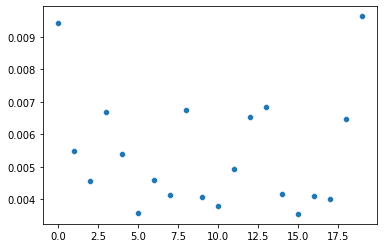

In [3]:
task_performance(task=v2_event_train)

In [13]:
fetch_docs(collection="content", env="prod")

ConnectionError: HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /test-fetch-docs?env=prod&collection=content&size=16 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x160fe0d60>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [5]:
v2_event_train(scan_minutes=200)

({'message': 'A handler for task: V2-TASK was not found',
  'code': 404,
  'data': {}},
 0.005793)

In [17]:
v2_fetch_corpus()

({'message': 'Success', 'code': 200, 'data': []}, 4.140812)

In [7]:
v2_fetch_index()

({'message': 'A handler for task: V2-TASK was not found',
  'code': 404,
  'data': {}},
 0.007873)

In [8]:
time_performance(fn=v2_event_train, fn_params=dict(scan_minutes=200), n_iter=30)

NameError: name 'time_performance' is not defined

In [ ]:
time_performance(fn=v2_random_train, n_iter=5)

In [ ]:
time_performance(fn=v2_event_train, n_iter=5)

In [19]:
v2_random_train()

(None, 5.683992)

In [ ]:
v2_event_train(scan_minutes=200)

In [20]:
v2_fetch_corpus()

({'message': 'Success',
  'code': 200,
  'data': [['6495e30dace492b1dcc527c4',
    'hello',
    '2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824'],
   ['6495b72eace492b1dcc5279f',
    'automated test',
    'b940d8ee906b605f278b7ee44489a598b9f399f477fc776a6d3ef22fe6e25ff8'],
   ['64945ceface492b1dcc526f5',
    'post',
    '72231043bc1807e6f740b235eb7511ecb33255a6a375435631196de8a9750d4b'],
   ['6494545bace492b1dcc526c9',
    'prueba',
    '655e786674d9d3e77bc05ed1de37b4b6bc89f788829f9f3c679e7687b410c89b'],
   ['649376a4ace492b1dcc526a3',
    'hello',
    '2cf24dba5fb0a30e26e83b2ac5b9e29e1b161e5c1fa7425e73043362938b9824'],
   ['649369d9ace492b1dcc52638',
    'veamos',
    'c065aea2ef9dfca9ae674a1a06efde023b19e201e0d50f2d493bbfda2160a8d8'],
   ['64936a7cace492b1dcc52656',
    'inedito',
    '33ba848808b0f7438cfa4f8b47b387e728739d9d8dfbfd9b7f6a11fc62483560'],
   ['649365f6ace492b1dcc5261b',
    'ey',
    '2bdd94c004581aa9f0d47b502c1e4e1bb83a7c2cf245b1b3c5d2670d9ae64ec4'],


In [21]:
v2_fetch_index(env="stage")

({'message': 'Success',
  'code': 200,
  'data': {'index': ['aaaadkfkfdkdkffkfkfkfkkfk',
    'abanico',
    'able',
    'ac',
    'acariciaba',
    'acaso',
    'accident',
    'accidente',
    'accidenteel',
    'acción',
    'account',
    'accumsan',
    'achieve',
    'achieving',
    'acuerdo',
    'acumulan',
    'ada',
    'adaptado',
    'adaptados',
    'adcula',
    'add',
    'address',
    'además',
    'adios',
    'adipiscing',
    'adiós',
    'adsfasdfasdf',
    'aenean',
    'afterthought',
    'agiliza',
    'ah',
    'ahora',
    'ahí',
    'ai',
    'ak',
    'akdf',
    'akdflaskdflaskfdlaskflaks',
    'akf',
    'aks',
    'aksfaksdfl',
    'alcanzar',
    'alejo',
    'alerces',
    'algoritmos',
    'alguien',
    'algún',
    'aliquam',
    'aliquet',
    'alkald',
    'alkalskdflaksf',
    'allows',
    'als',
    'alskdf',
    'also',
    'alterada',
    'alterna',
    'alternativas',
    'ama',
    'amarte',
    'amazon',
    'amenizar',
    'amet',
    'ami

In [ ]:
time_performance(fn=v2_fetch_corpus, n_iter=5)

In [ ]:
time_performance(fn=v2_random_train, n_iter=5)

In [ ]:
time_performance(fn=v2_event_train, n_iter=5)